# Importing Data

In [1]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs

from scipy.optimize import curve_fit



In [2]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()

In [3]:
df_copy = df_copy[df_copy['Sample type'] == 'Spring water']    

In [ ]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']



df_copy['Si_mol/l'] = df_copy['Si_mM'] / 1000
df_copy['Si_uM'] = df_copy['Si_mM'] * 1000  

In [5]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)


In [6]:
df_copy = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate distance for Abra samples for their longitude. Do longitude 85.5984 minus the longitude of the sample. Then convert to meters to give a new 'x' column
df_copy['x'] = (85.5984 - df_copy['Longitude']) * 111000

# calculate elevation difference between df_abra['Elevation'] and the elevation of the ridge
df_copy['y'] = 2600 - df_copy['Elevation']

df_copy['x+y'] = df_copy['x'] + df_copy['y']

# calculate sqrt(x^2 + y^2) for each sample
df_copy['distance_from_ridge'] = np.sqrt(df_copy['x']**2 + df_copy['y']**2)

df_copy['2(x+y)'] = 2 * df_copy['x+y']


# print x+y, distance from ridge and 2(x+y)
#print(df_copy[['x+y', 'distance_from_ridge', '2(x+y)', 'Sample ID']])

In [7]:
# Initialize a dictionary to store h distributions
h_distributions = {}

# Loop through each sample to calculate the h range
for index, row in df_copy.iterrows():
    sample_id = row['Sample ID']  # Assuming 'Sample ID' uniquely identifies each sample
    # Generate 1000 evenly spaced h values for the sample
    h_values = np.linspace(row['distance_from_ridge'], row['2(x+y)'], 1000)
    # Store in the dictionary
    h_distributions[sample_id] = h_values
    
    

# Modelling

In [ ]:
variable = 'Si_uM'

# define Co
C_zero = df_copy[variable].min()
C_max = df_copy[variable].max()

#print(C_zero)
#print(C_max)

# C_eq = “380 μmol/L SiO2” ([Maher and Chamberlain, 2014

C_eq = 380 


C_eq = C_max

# Cmax we have is greater than C_eq they have. Threfore we wil set our Cmax as C_eq. Is this valid???

In [ ]:
tau = np.exp(2)

phi = 0.15 ##### NEED TO CHANGE THIS

# fw is practically = 1 for our k and m values so will approximate Rn to Rn_max

rho_min = 2.67 # g/cm^3 density of plagioclase

rho_sf = 1000 * rho_min / phi # g/L

#######

# # nautral log of k is -11.2 from USGS
# # for now taking constant in mol/m^2/s

# k_eff = np.exp(-11.2)



##########

#Now using time dependent rate constant from White and Brantley

# convert k_eff to mol/m^2/year
#k_eff = k_eff * 60 * 60 * 24 * 365

#print(k_eff)








# specific surface area. For now taking constant, the same as Maher and Chamberlain 2014
a_surf = 0.1

# percentage of plagioclase in rock. Update this value when you have a better idea...
x_r =  0.36

########

# Calculate rn_max = rho_sf * k_eff * a_surf * x_r in moles per liter per year
#rn_max = rho_sf * k_eff * a_surf * x_r

#print(rn_max)
# check this again

######

#t_eq = C_eq / rn_max

#print(t_eq)



# Dw = h * phi / t_eq

# C = C_zero / (1 + ((tau * Dw) / omega)) + C_eq * (((tau * Dw) / omega) / (1 + ((tau * Dw) / omega)))








431.22944712731487
276331.8297191834
1.672602492794499e-09


In [10]:
# Initialize dictionaries for results
omega_results = {}
residence_time_results = {}

# Loop through each sample
for sample_id, h_values in h_distributions.items():
    row = df_copy[df_copy['Sample ID'] == sample_id].iloc[0]
    C_values = row[variable]  # Concentration for the sample
    
    omega_values = []
    residence_times = []

    for h in h_values:
        # Compute Dw
        Dw = h * phi / t_eq

        # Compute omega (q)
        omega = (tau * Dw * (C_values - C_eq)) / (C_zero - C_values)
        omega_values.append(omega)

        
        # Compute residence time
        residence_time = h / omega
        residence_times.append(residence_time)  # Convert to years

    omega_results[sample_id] = omega_values
    residence_time_results[sample_id] = residence_times


/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_34253/3196544867.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  residence_time = h / omega
/var/folders/9m/bjwjgvv11dxfyfxcm241dlrh0000gn/T/ipykernel_34253/3196544867.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  omega = (tau * Dw * (C_values - C_eq)) / (C_zero - C_values)


In [11]:
# define C'
df_copy['C_prime'] = df_copy[variable] / C_zero

# Initialize lists for plotting
lowest_h_residence_times = []
middle_h_residence_times = []
highest_h_residence_times = []
c_prime_values = []

# Loop through each sample
for sample_id, h_values in h_distributions.items():
    # Extract the h distribution and corresponding results
    residence_times = residence_time_results[sample_id]
    C_prime = df_copy.loc[df_copy['Sample ID'] == sample_id, 'C_prime'].values[0]  # Constant per sample

    # Extract lowest, middle, and highest h indices
    lowest_h_index = 0
    highest_h_index = len(h_values) - 1
    middle_h_index = len(h_values) // 2

    # Append the corresponding residence times
    lowest_h_residence_times.append(residence_times[lowest_h_index])
    middle_h_residence_times.append(residence_times[middle_h_index])
    highest_h_residence_times.append(residence_times[highest_h_index])
    
    # Append the constant C_prime
    c_prime_values.append(C_prime)

# Convert lists to numpy arrays
lowest_h_residence_times = np.array(lowest_h_residence_times)
middle_h_residence_times = np.array(middle_h_residence_times)
highest_h_residence_times = np.array(highest_h_residence_times)
c_prime_values = np.array(c_prime_values)


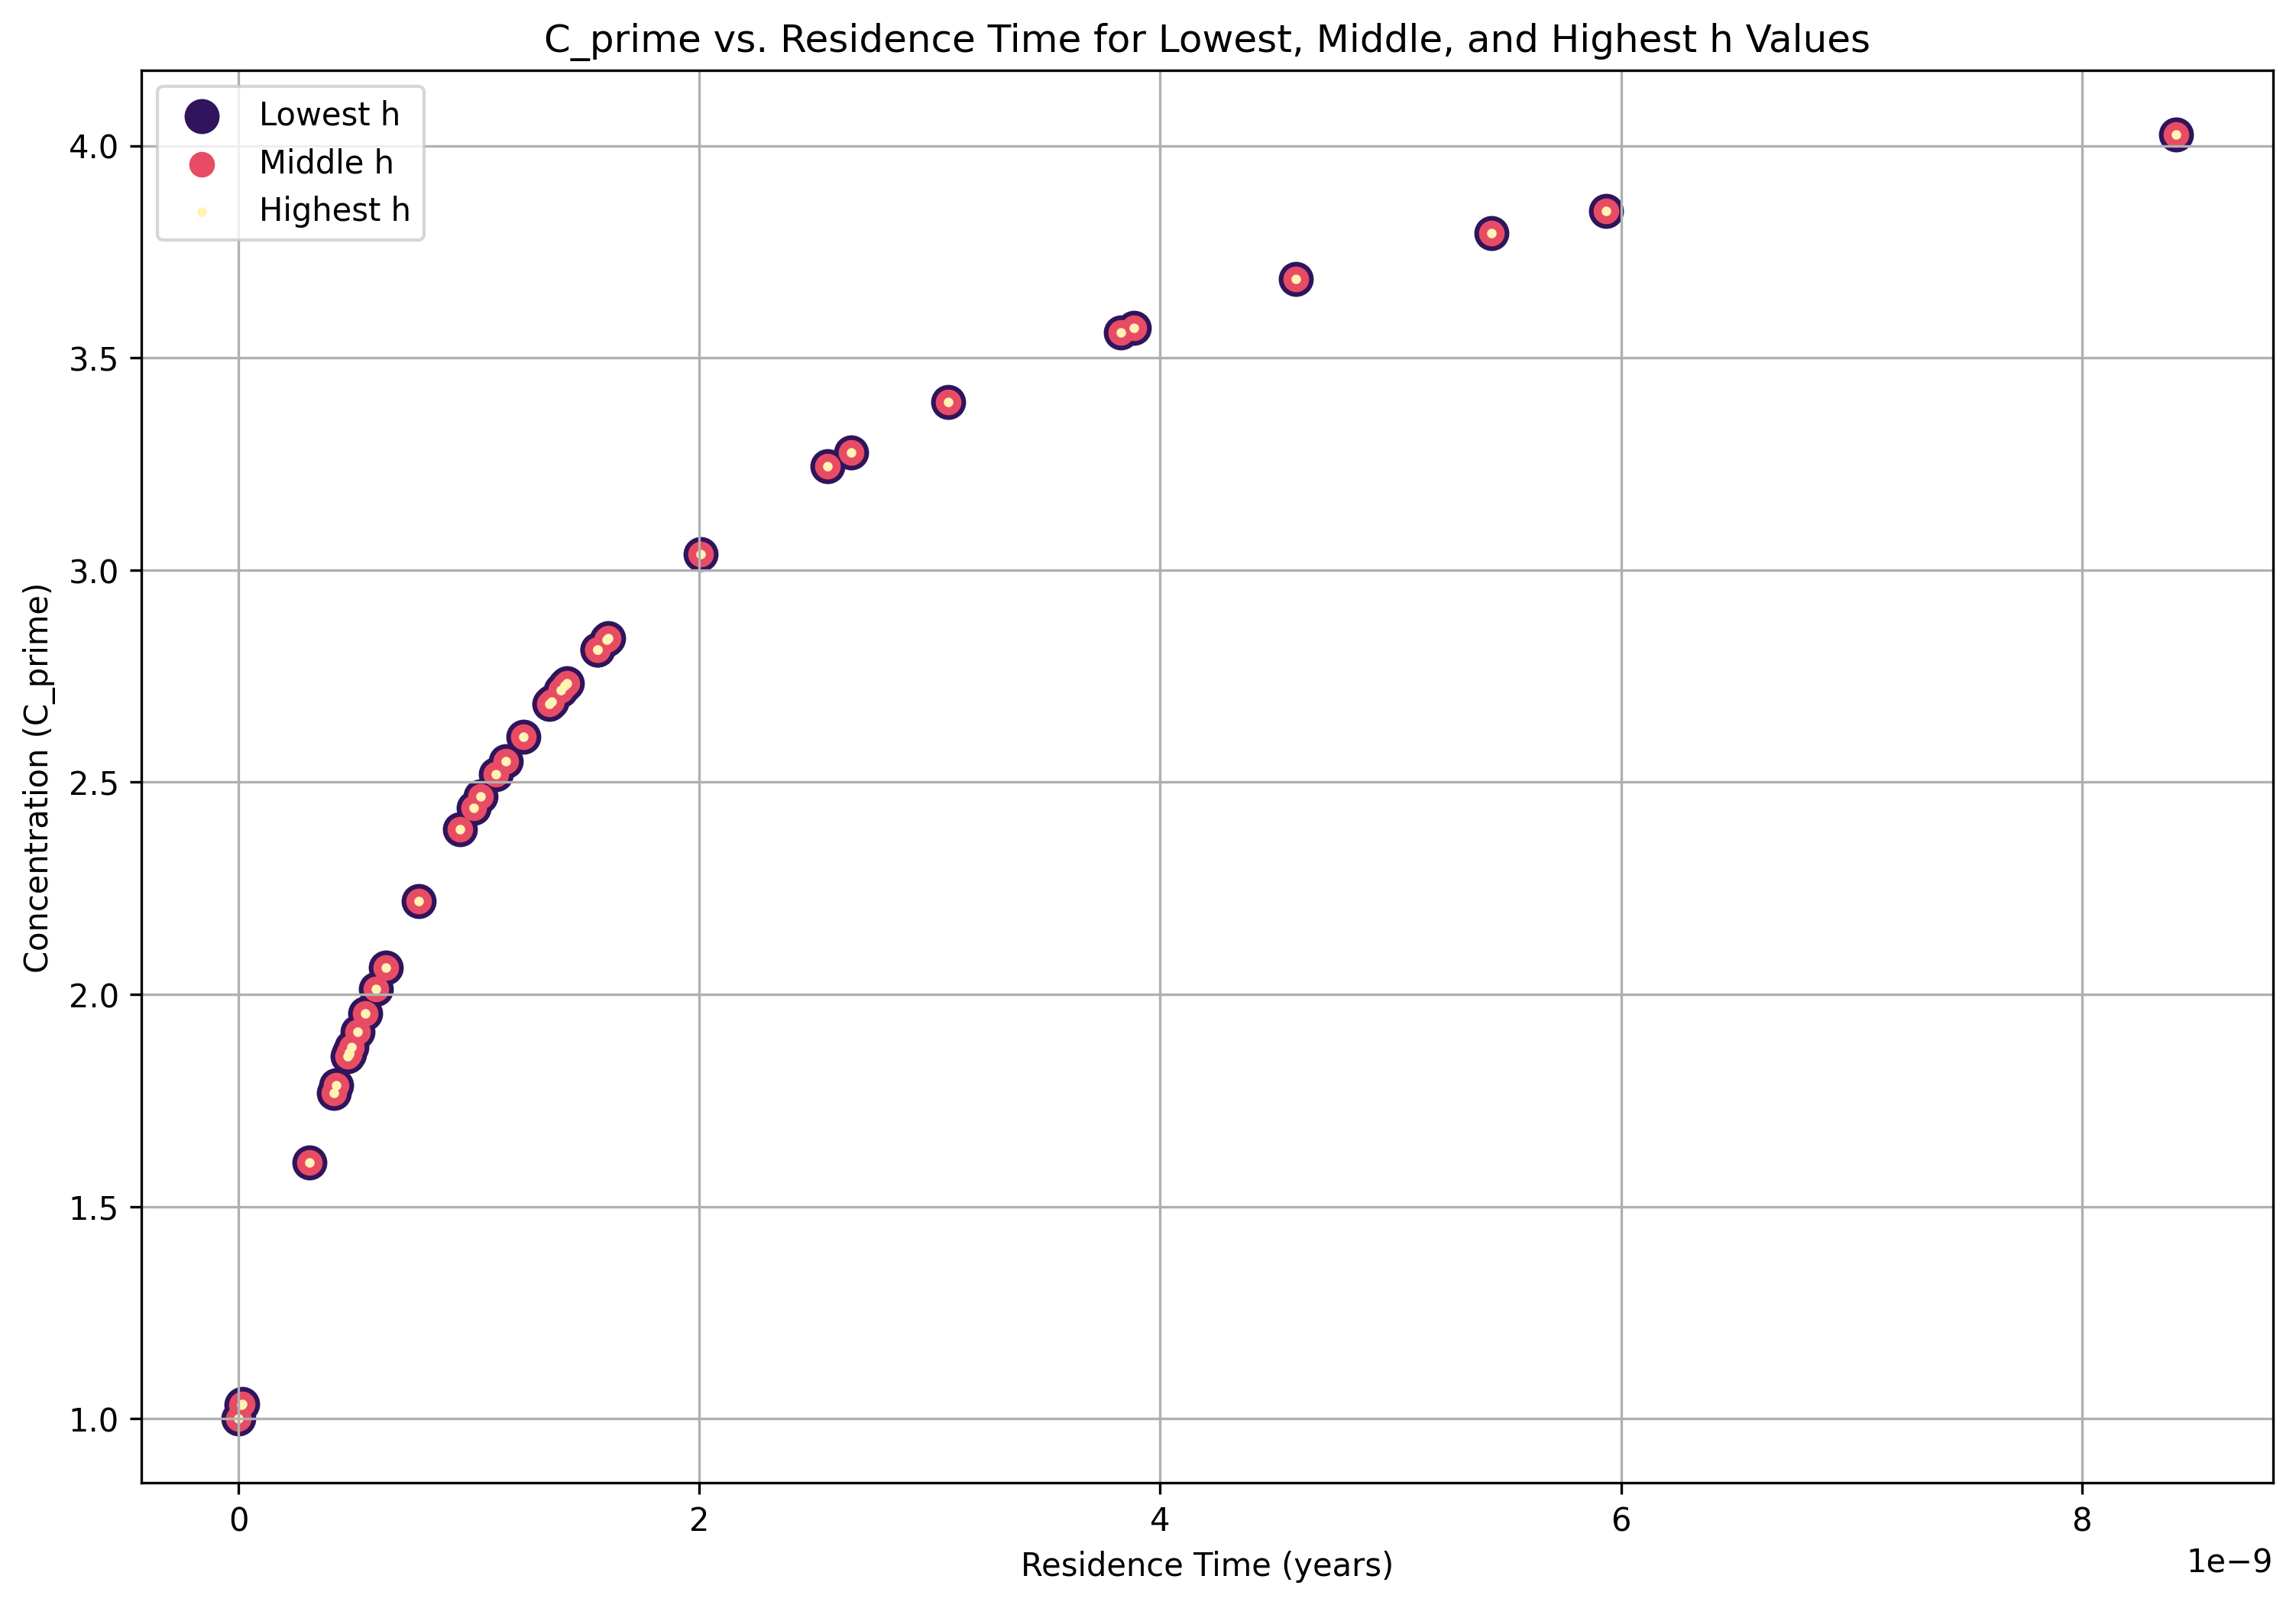

In [12]:
# Plot the results
plt.figure(figsize=(12, 8), dpi = 300)

# Plot for lowest h values
plt.scatter(lowest_h_residence_times, c_prime_values, label='Lowest h', color='#30145c', marker='o', s = 100)

# Plot for middle h values
plt.scatter(middle_h_residence_times, c_prime_values, label='Middle h', color='#e84c64', marker='o', s = 50)

# Plot for highest h values
plt.scatter(highest_h_residence_times, c_prime_values, label='Highest h', color='#fff4b4', marker='o', s = 4)

# Customize plot
plt.xlabel('Residence Time (years)')
plt.ylabel('Concentration (C_prime)')
plt.title('C_prime vs. Residence Time for Lowest, Middle, and Highest h Values')
plt.legend()
plt.grid()
plt.savefig('Model2.pdf', dpi = 300)
plt.show()